In [1]:
import matplotlib.pyplot as plt 
from glob import glob
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization

import tensorflow.keras.utils as np_utils
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
#import tensorflow_addons as tfa
from keras.models import Model

from matplotlib.colors import ListedColormap
#from keras.utils.training_utils import multi_gpu_model


from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import os
import pandas as pd


import pickle
from joblib import dump, load

## 1.GPU 메모리 자동 증가 설정

In [2]:
# GPU 메모리 자동 증가 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# 2.Loading data

In [3]:
%%time
grids=500
base='/tf/'
data = np.load(base+str(grids)+'data.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

CPU times: user 818 ms, sys: 189 ms, total: 1.01 s
Wall time: 1.01 s


# 3.Reshaping & Normalization

In [4]:
%%time
#num_pixels = X_train.shape[1] * X_train.shape[2]
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0],grids,grids,1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0],grids,grids,1)).astype('float32')
X_val = X_val.reshape((X_val.shape[0],grids,grids,1)).astype('float32')
print(X_train.shape)
#Normalization                          
maxvalue=X_train[X_train>0].max()

X_train = X_train / maxvalue
X_train[np.isnan(X_train)==True]=0
X_train[np.isinf(X_train)==True]=0

X_test = X_test / maxvalue
X_test[np.isnan(X_test)==True]=0
X_test[np.isinf(X_test)==True]=0

X_val = X_val / maxvalue
X_val[np.isnan(X_val)==True]=0
X_val[np.isinf(X_val)==True]=0

(252, 500, 500)
(252, 500, 500, 1)
CPU times: user 549 ms, sys: 253 ms, total: 802 ms
Wall time: 798 ms


## add) Masking SB <26 (brighter) or >=26 (darker)

In [5]:
X_test[X_test<26]=0

# 4. one-hot encoding outputs

In [5]:
%%time
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)
num_classes = y_test.shape[1]

CPU times: user 1.12 ms, sys: 1.13 ms, total: 2.26 ms
Wall time: 1.49 ms


### Gpu 메모리 clear 1

In [ ]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

### Gpu 메모리 clear 2

In [30]:

def clear_tf_gpu_memory():
    tf.keras.backend.clear_session()

clear_tf_gpu_memory()

# 5. Model building

In [6]:
strategy = tf.distribute.MirroredStrategy()
Droprate=0.2
def baseline_model():
# create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(grids,grids, 1),strides=(1, 1), activation='relu',padding='same'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(Droprate))
    
    model.add(Conv2D(64, (3, 3), activation='relu',strides=(1, 1),padding='same'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(Droprate))
    
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))

    #model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])    
    model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=True), optimizer='adam', metrics=['accuracy'])    
    # Compile model
    return model

# build the model
with strategy.scope():
    model=baseline_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1000, 1000, 32)    832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 500, 500, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 500, 500, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 500, 500, 164)     47396     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 250, 250, 164)    0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 250, 250, 164)     0

# 6. Fitting Model

In [10]:
#start_time = tf.timestamp()

# Fit the model
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=2)
# Final evaluation of the model

save_dir = "/tf/Results/models/%i/Log/CNN/"%grids
model_name = '%i_CV2_32_5_64_3_FL'%(grids)#_Drop_0.2
model_path = os.path.join(save_dir, model_name+'.h5')
model.save(model_path)
print('\n Saved trained model at %s ' % model_path)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))



# 실행 시간 계산
#end_time = tf.timestamp()
#execution_time = end_time - start_time
#print("Execution time: ", execution_time.numpy(), " seconds")

# history 객체를 저장
dump(history.history, 'Results/histories/%i/Log/CNN/'%grids+model_name+'.joblib')

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

InternalError: Graph execution error:

Detected at node 'Adam/NcclAllReduce' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 505, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 687, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 740, in _run_callback
      ret = callback()
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 821, in inner
      self.ctx_run(self.run)
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 782, in run
      yielded = self.gen.send(value)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 540, in execute_request
      self.do_execute(
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-10-fe369fde81ab>", line 4, in <module>
      history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=2)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/utils.py", line 151, in _all_reduce_sum_fn
      return distribution.extended.batch_reduce_to(tf.distribute.ReduceOp.SUM,
Node: 'Adam/NcclAllReduce'
Detected at node 'Adam/NcclAllReduce' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 505, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 687, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 740, in _run_callback
      ret = callback()
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 821, in inner
      self.ctx_run(self.run)
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 782, in run
      yielded = self.gen.send(value)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 540, in execute_request
      self.do_execute(
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-10-fe369fde81ab>", line 4, in <module>
      history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=2)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/utils.py", line 151, in _all_reduce_sum_fn
      return distribution.extended.batch_reduce_to(tf.distribute.ReduceOp.SUM,
Node: 'Adam/NcclAllReduce'
2 root error(s) found.
  (0) INTERNAL:  NCCL: unhandled system error. Set NCCL_DEBUG=WARN for detail.
	 [[{{node Adam/NcclAllReduce}}]]
	 [[Adam/Adam/group_deps/NoOp/_125]]
  (1) INTERNAL:  NCCL: unhandled system error. Set NCCL_DEBUG=WARN for detail.
	 [[{{node Adam/NcclAllReduce}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_2637]

# Confusion Matrix

In [11]:
y_pred=model.predict(X_test)
confM=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))
class_totals = np.sum(confM, axis=1)
cm_norm = confM / class_totals[:, np.newaxis]
np.savez('/tf/Results/confusion/'+str(grids)+'/Log/CNN/'+model_name+'.npz', confusion=confM)

3/3 [==============================] - 1s 122ms/step


NameError: name 'model_name' is not defined

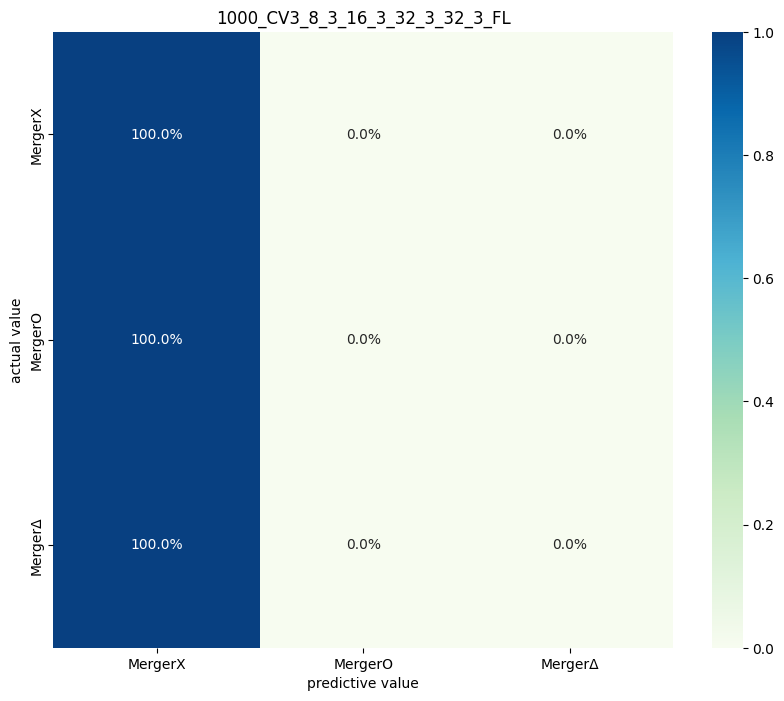

In [11]:
labels=['MergerX','MergerO','MergerΔ']
#print(data)
# Drawing confusion matrix with seaborn
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm,annot=True,fmt=".1%",cmap='GnBu',xticklabels=labels, yticklabels=labels)
plt.xlabel('predictive value')
plt.ylabel('actual value')

plt.title(model_name)
plt.show()

# Classification Report

In [85]:
report=classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1),output_dict=True)

df=pd.DataFrame(report).transpose()
df.to_hdf('Results/confusion/'+str(grids)+'/Log/CNN/'+model_name+'.h5',key='Galaxy',mode='w')   
df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.675000,1.000000,0.805970,54.000
1,0.000000,0.000000,0.000000,21.000
2,0.000000,0.000000,0.000000,5.000
accuracy,0.675000,0.675000,0.675000,0.675
macro avg,0.225000,0.333333,0.268657,80.000
weighted avg,0.455625,0.675000,0.544030,80.000


## -----   -----   -----   -----   -----   -----   -----   -----   ----- 


## 7. Drawing Filters and Feature maps

### 7-1) summary of model

In [86]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name: continue
    # summarize output shape
    #print(i, layer.name, layer.output.shape)
    filters, biases = layer.get_weights()
    print(i,layer.name, filters.shape)

0 conv2d_7 (5, 5, 1, 8)
4 conv2d_8 (3, 3, 8, 16)
8 conv2d_9 (3, 3, 16, 32)
12 conv2d_10 (3, 3, 32, 32)


### 7-2) Drawing trained filters

In [127]:
model.layers[0].output#,outputs1.summary()

<KerasTensor: shape=(None, 1000, 1000, 32) dtype=float32 (created by layer 'conv2d_2')>

In [157]:
filters1.shape, feature_maps.shape

((5, 5, 1, 32), (1000, 1000, 1, 32))

(5, 5, 1, 32)


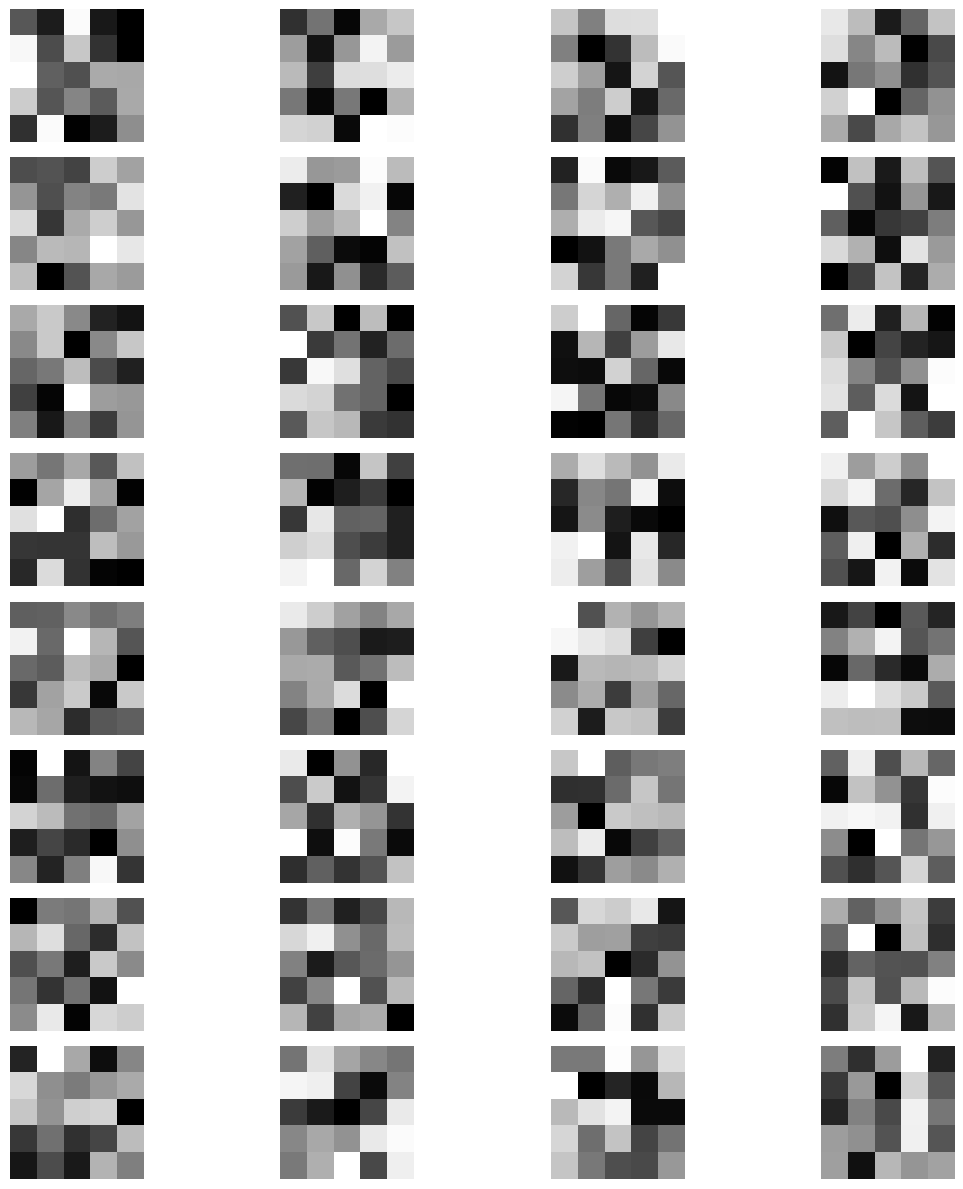

In [9]:
# 필터를 이미지로 변환하여 시각화합니다.
filters1, biases1 = model.layers[0].get_weights()
fig=plt.figure(figsize=(12, 12))
print(filters1.shape)
for i in range(filters1.shape[3]):
    ax=plt.subplot(8, 4, i + 1)
    plt.imshow(filters1[:, :, 0, i], cmap='gray')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()
   

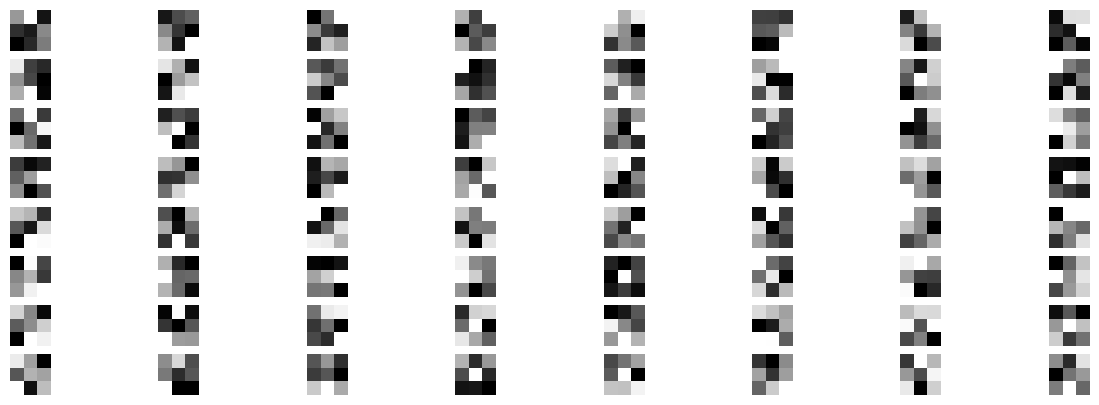

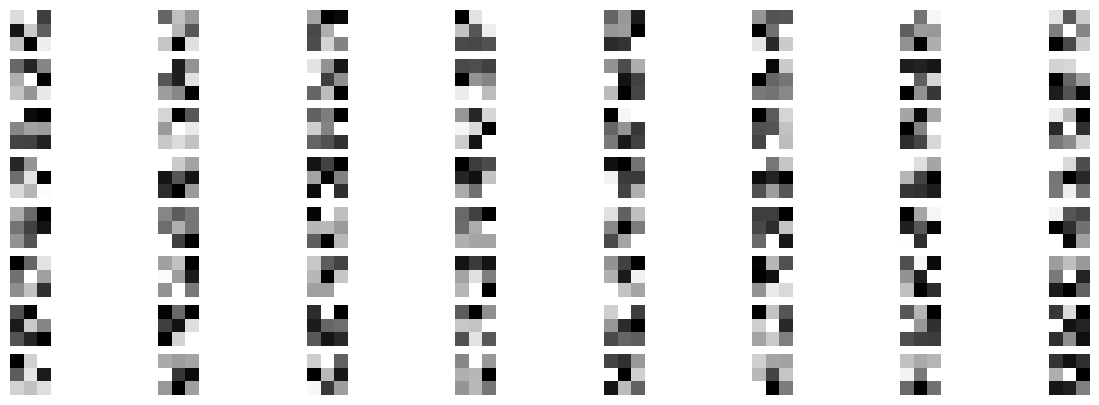

In [245]:
filters2, biases2 = model.layers[3].get_weights()
plt.figure(figsize=(15, 5))
for i in range(filters2.shape[3]):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filters2[:, :, 0, i], cmap='gray')
    plt.axis('off')
    
plt.show()
plt.figure(figsize=(15, 5))
for i in range(filters2.shape[3]):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filters2[:, :, 1, i], cmap='gray')
    plt.axis('off')
plt.show()

### 7-3) Drawing feature_maps

In [14]:
 #summarize feature map shapes 
for i in range(len(model.layers)):
    layer=model.layers[i]
    if 'conv' not in layer.name : continue
    print(i,layer.name,layer.output.shape)

0 conv2d (None, 1000, 1000, 8)
4 conv2d_1 (None, 500, 500, 16)
8 conv2d_2 (None, 250, 250, 32)
12 conv2d_3 (None, 125, 125, 32)


In [92]:
model.summary()
print(test.shape)
# 1: 배치 크기(batch size)로서, 단일 이미지를 하나의 배치로 처리하므로 1입니다.
# 1000: 이미지의 높이(height)로서, 1000입니다.
# 1000: 이미지의 너비(width)로서, 1000입니다.
# 1: 이미지의 채널(channel) 개수로서, 흑백 이미지이므로 1입니다.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 1000, 1000, 8)     208       
                                                                 
 batch_normalization_7 (Batc  (None, 1000, 1000, 8)    32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 500, 500, 8)      0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 500, 500, 8)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 500, 500, 16)      1168      
                                                                 
 batch_normalization_8 (Batc  (None, 500, 500, 16)    

In [15]:
outlay=[model.layers[i].output for i in [0,4,8,12]]
outputs1=Model(inputs=model.inputs,outputs=outlay)

In [16]:
test=np.expand_dims(X_test[1], axis=0)
print(y_test[1])
feature_maps=outputs1.predict(test)

[1. 0. 0.]
1/1 [==============================] - 0s 339ms/step


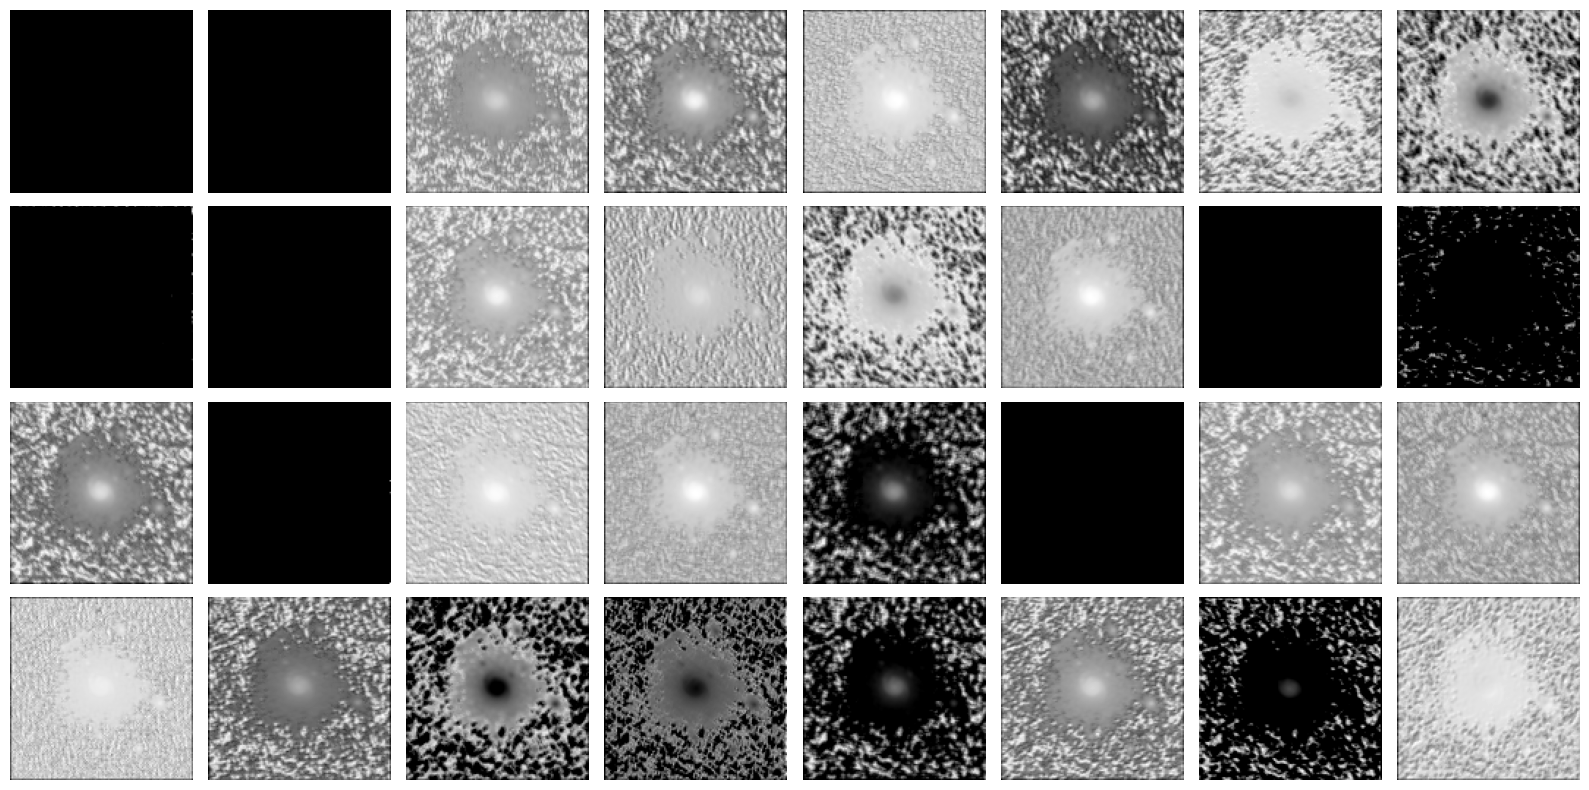

In [27]:

fig=plt.figure(figsize=(16,8))
for i in range(32):
    ax=plt.subplot(4,8,i+1)
    plt.imshow(feature_maps[3][0,:,:,i],cmap='gray')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()


In [91]:
fig=plt.figure(figsize=(12,12))
for i in range(64):
    ax=plt.subplot(8,8,i+1)
    plt.imshow(feature_maps[3][0, :, :, i],cmap='gray')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

IndexError: index 8 is out of bounds for axis 3 with size 8

In [28]:
np.sqrt(128)

11.313708498984761

## 8. Drawing Hisotries(loss,accuracy) of the models

In [37]:
FL=glob('Results/histories/1000/Log/CNN/*.joblib')

0
Results/histories/1000/Log/CNN/1000_CV3_8_3_16_3_32_3_FL.joblib


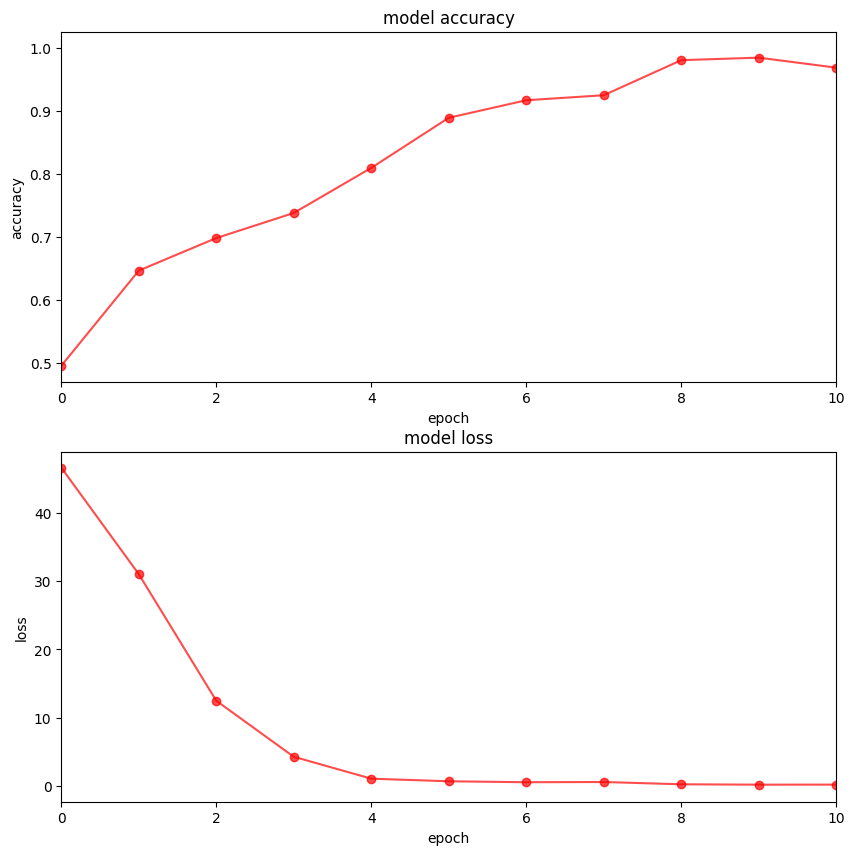

In [39]:
# 저장된 history 객체를 로드

FL=glob('Results/histories/1000/Log/CNN/*.joblib')
# plotting the metrics
fig = plt.figure(figsize=(10,10))
plt.subplot(2,1,1)

for i in range(len(FL)) :
    print(i)
    history=load(FL[i])
    labels=FL[i].split('/')[-1].split('.joblib')[0]
    
    
    string=labels.split('_')
    
    if 'FL' in string: colors='r'
    else : colors='b'

    if 'CV2' in string : line='-'
    elif 'CV1' in string : line='--'
    else : line='-'
    
    if 'CV3' in string : colors=colors+'o'
    
    
    
    plt.plot(history['accuracy'],colors,linestyle=line,alpha=0.7)
    #plt.plot(history['val_accuracy'],linestyle='--',c=colors[i],alpha=0.5)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    #lt.legend(loc='upper right',fontsize=8)
    #plt.ylim(0.86,0.98)
    plt.xlim(0,10)
    break
plt.subplot(2,1,2)

for i in range(len(FL)) :
    #fig = plt.figure(figsize=(10,10))
    print(FL[i])
    history=load(FL[i])
    labels=FL[i].split('/')[-1].split('.joblib')[0]
    string=labels.split('_')
    
    if 'FL' in string: colors='r'
    else : colors='b'

    if 'CV2' in string : line='-'
    elif 'CV1' in string : line='--'
    else : line='-'
    
    if 'CV3' in string : colors=colors+'o'
        
    plt.plot(history['loss'],colors,linestyle=line,alpha=0.7)
    #plt.plot(history['val_loss'],linestyle='--',c=colors[i],alpha=0.5)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(loc='upper right',fontsize=8)
    #plt.ylim(0.1,0.3)
    plt.xlim(0,10)
    break
plt.show()

